In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("======================BASIC=========================")
df = pd.read_json("data/classes.json").sort_values("Count", ascending=False).reset_index(drop=True)
print(df.head(3))
print("====================================================")

# fuse column "Plant" and column "Status" into column "Plant-Status" for plotting
print("======================FUSED========================")
df_fused = df[["Plant", "Status", "Count"]].assign(Plant_Status=df["Plant"] + '-' + df["Status"])[["Plant_Status", "Count"]].reset_index(drop=True)
print(df_fused.head(3))
print("====================================================")

# group by plant, sum number of pictures and count number of statuses
print("================GROUPED BY PLANT===================")
df_grouped = df.groupby('Plant').agg({'Count': 'sum', 'Status': 'count'}).sort_values("Count", ascending=False).reset_index()
print(df_grouped)
print("===================================================")

======================BASIC=========================
     Plant                           Status  Count
0   Orange  Haunglongbing_(Citrus_greening)   5507
1   Tomato    Tomato_Yellow_Leaf_Curl_Virus   5357
2  Soybean                          healthy   5090
======================FUSED========================
                             Plant_Status  Count
0  Orange-Haunglongbing_(Citrus_greening)   5507
1    Tomato-Tomato_Yellow_Leaf_Curl_Virus   5357
2                         Soybean-healthy   5090
================GROUPED BY PLANT===================
          Plant  Count  Status
0        Tomato  18160      10
1        Orange   5507       1
2       Soybean   5090       1
3         Grape   4062       4
4          Corn   3852       4
5         Apple   3171       4
6         Peach   2657       2
7   Pepper_bell   2475       2
8        Potato   2152       3
9        Cherry   1906       2
10       Squash   1835       1
11   Strawberry   1565       2
12    Blueberry   1502       1
13    Ras

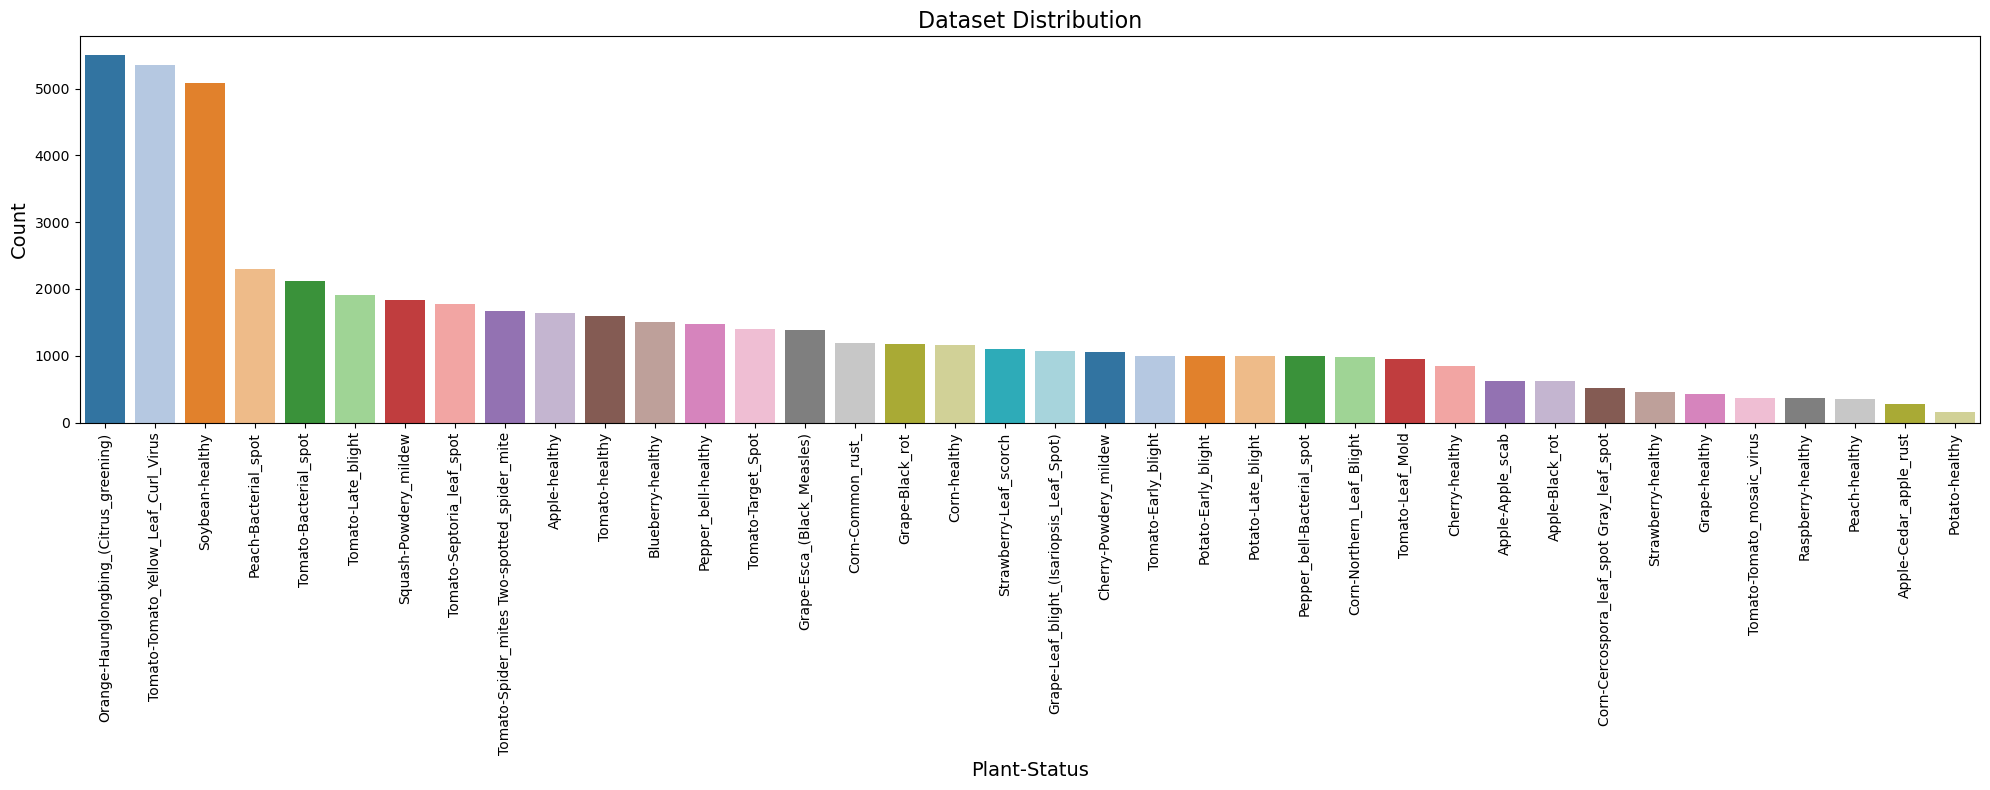

In [2]:
plt.figure(figsize=(20,8))
sns.barplot(data=df_fused, x="Plant_Status", y="Count", hue="Plant_Status", legend=False, palette="tab20")
plt.title("Dataset Distribution", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Plant-Status", fontsize=14)
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

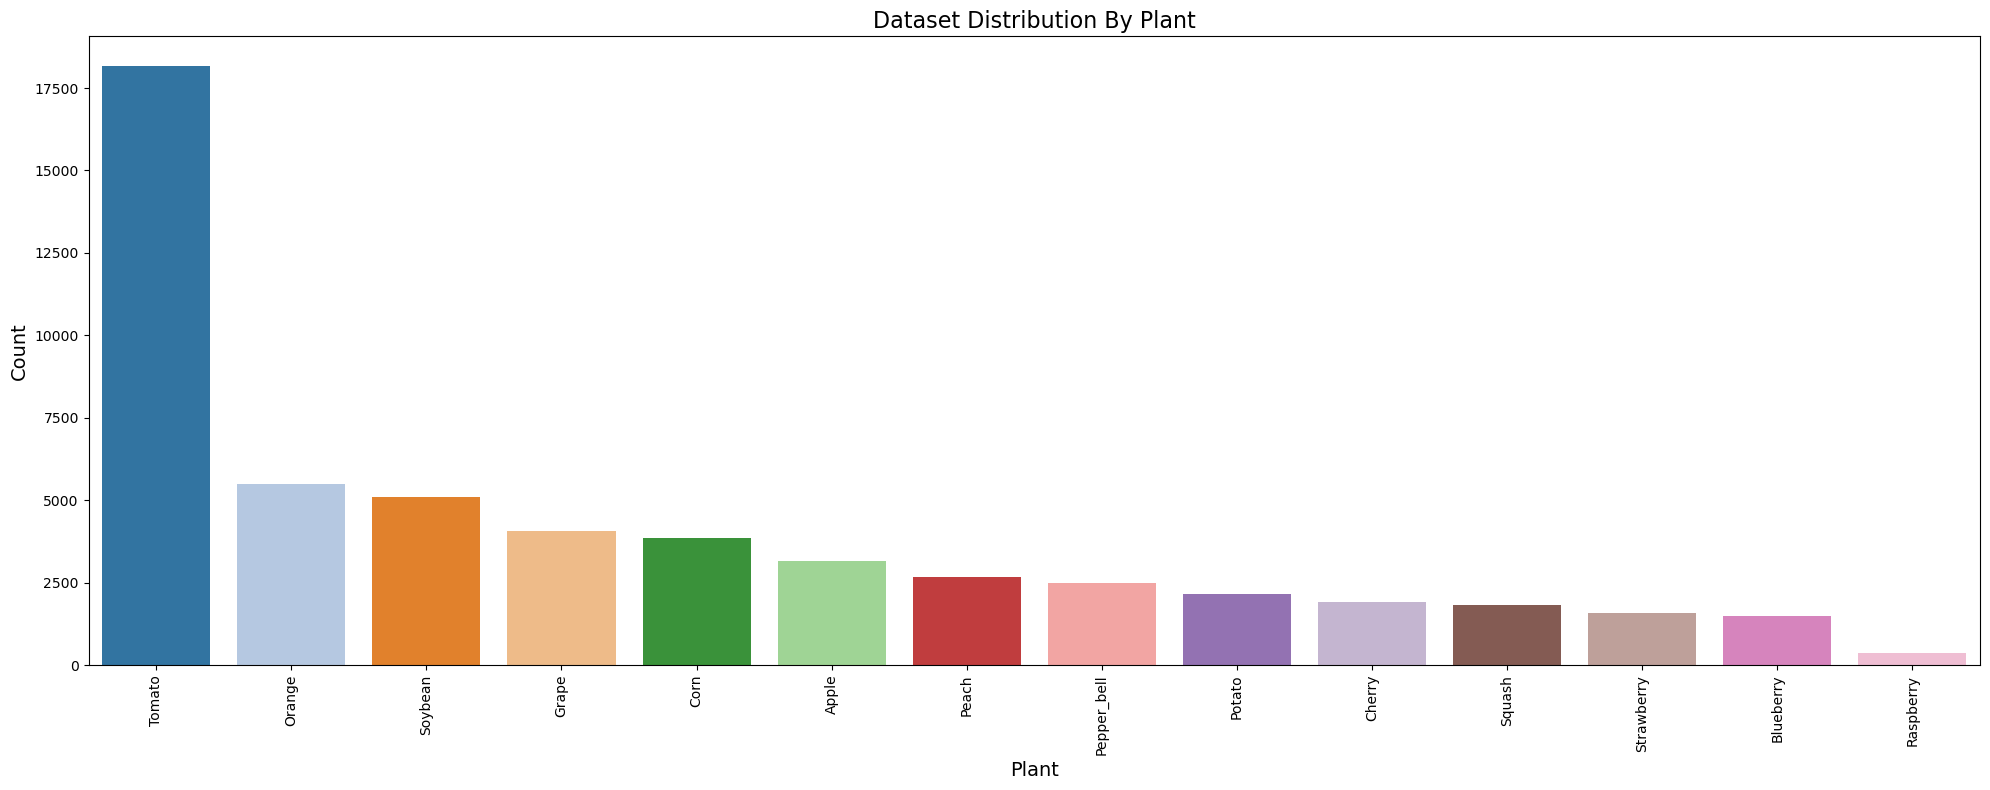

In [3]:
plt.figure(figsize=(20,8))
sns.barplot(data=df_grouped, x="Plant", y="Count", hue="Plant", legend=False, palette="tab20")
plt.title("Dataset Distribution By Plant", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Plant", fontsize=14)
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

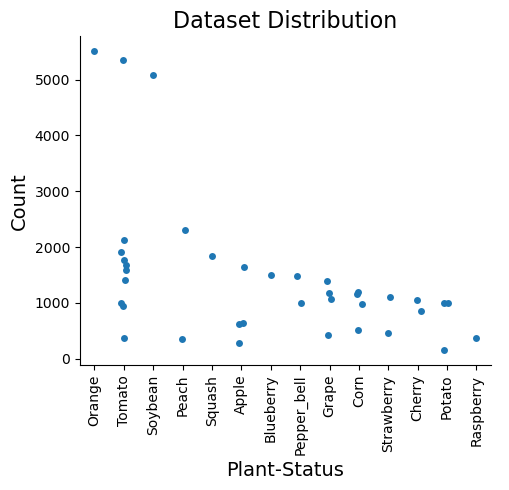

In [4]:
plt.figure(figsize=(20,8))
sns.catplot(data=df, x="Plant", y="Count")
plt.title("Dataset Distribution", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Plant-Status", fontsize=14)
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [8]:
import random
from pathlib import Path
from PIL import Image

JSON_PATH = "data/classes.json"
IMAGES_ROOT = Path("data/images")
SAMPLE_PER_CATEGORY = 3
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

==== DATASET SUMMARY ====
Total images: 54,305
Number of Plant-Status categories (rows): 38
Unique Plants: 14
Unique Statuses: 21

Count statistics (per category):
count      38.000000
mean     1429.078947
std      1271.738784
min       152.000000
25%       686.000000
50%      1092.500000
75%      1631.500000
max      5507.000000

Top 10 categories by reported count:
  Plant                               Status  Count
 Orange      Haunglongbing_(Citrus_greening)   5507
 Tomato        Tomato_Yellow_Leaf_Curl_Virus   5357
Soybean                              healthy   5090
  Peach                       Bacterial_spot   2297
 Tomato                       Bacterial_spot   2127
 Tomato                          Late_blight   1909
 Squash                       Powdery_mildew   1835
 Tomato                   Septoria_leaf_spot   1771
 Tomato Spider_mites Two-spotted_spider_mite   1676
  Apple                              healthy   1645

Bottom 10 categories by reported count:
     Plant       

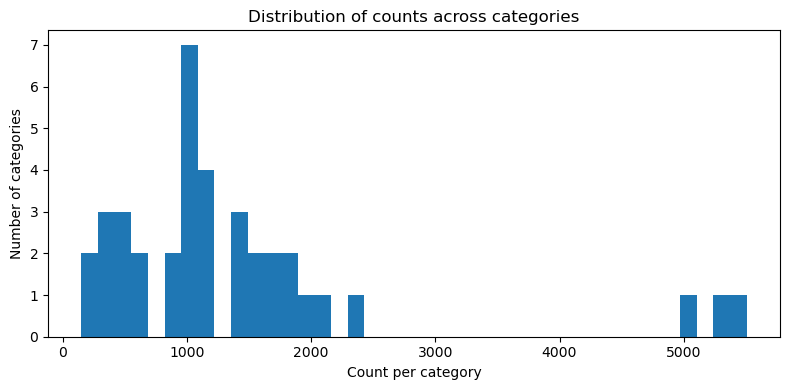

In [6]:
# Basic summary stats
total_images_reported = int(df["Count"].sum())
num_categories = len(df)               # distinct Plant-Status rows
num_plants = df["Plant"].nunique()
num_statuses = df["Status"].nunique()
counts_desc = df["Count"].describe()

print("==== DATASET SUMMARY ====")
print(f"Total images: {total_images_reported:,}")
print(f"Number of Plant-Status categories (rows): {num_categories}")
print(f"Unique Plants: {num_plants}")
print(f"Unique Statuses: {num_statuses}")
print()
print("Count statistics (per category):")
print(counts_desc.to_string())
print()

# Top / bottom categories
top = df.sort_values("Count", ascending=False).head(10)
bottom = df.sort_values("Count", ascending=True).head(10)
print("Top 10 categories by reported count:")
print(top[["Plant", "Status", "Count"]].to_string(index=False))
print()
print("Bottom 10 categories by reported count:")
print(bottom[["Plant", "Status", "Count"]].to_string(index=False))
print()

# Plot distribution of counts
plt.figure(figsize=(8,4))
plt.hist(df["Count"], bins=40)
plt.xlabel("Count per category")
plt.ylabel("Number of categories")
plt.title("Distribution of counts across categories")
plt.tight_layout()
plt.show()

Found 38 categories with images.


/tmp/ipykernel_23986/3972181209.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.985])


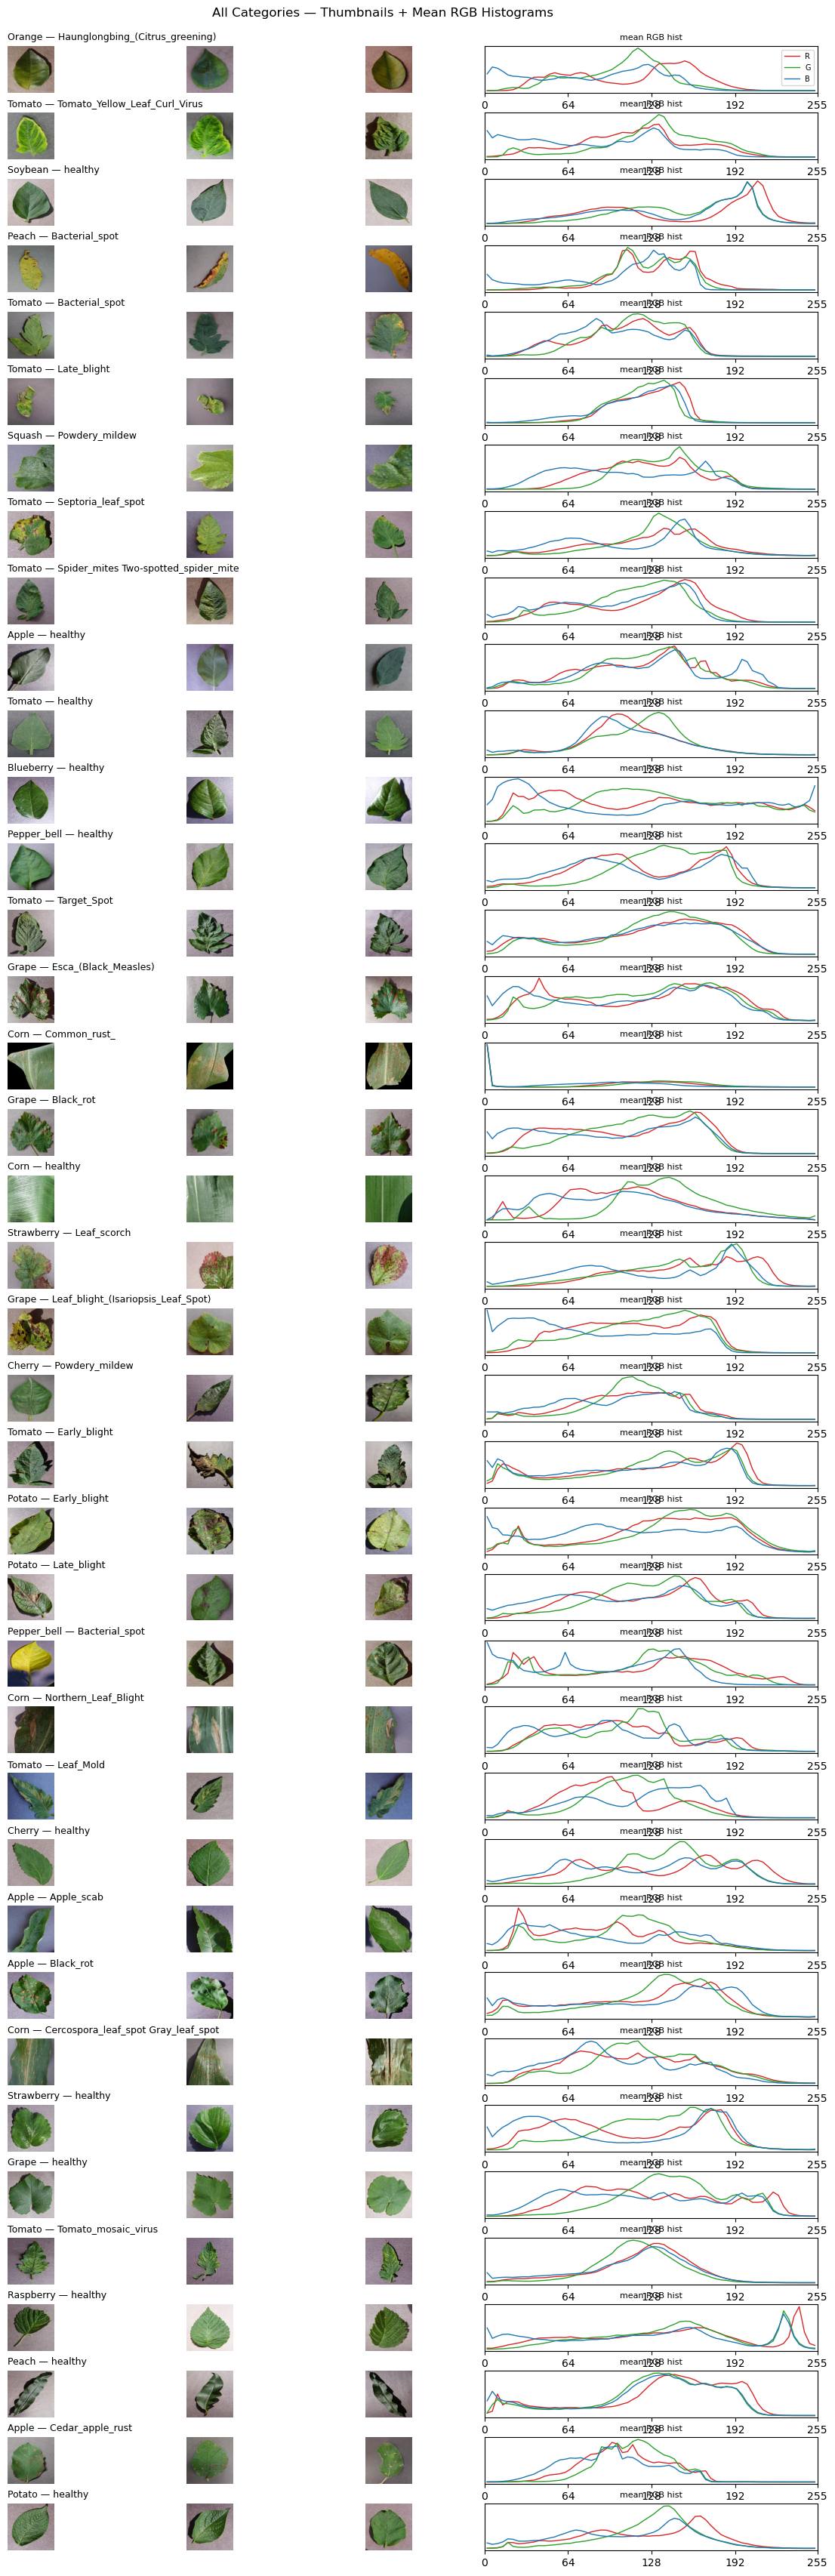

In [7]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def folder_for(plant, status, root=IMAGES_ROOT):
    p = root / f"{plant}___{status}"
    return p if p.exists() and p.is_dir() else None

cats = []
for _, row in df.iterrows():
    plant, status = row["Plant"], row["Status"]
    folder = folder_for(plant, status)
    if folder:
        imgs = [p for p in sorted(folder.glob("*")) if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tiff"}]
        if imgs:
            cats.append((plant, status, folder, imgs))

rows = len(cats)
print(f"Found {rows} categories with images.")

def mean_rgb_histogram(img_paths, bins=64):
    agg = np.zeros((3, bins), dtype=np.float64)
    edges = None
    for p in img_paths:
        try:
            im = Image.open(p).convert("RGB")
            arr = np.array(im)
            for ch in range(3):
                hist, edges = np.histogram(arr[..., ch].ravel(), bins=bins, range=(0,255))
                agg[ch] += hist
        except Exception:
            continue
    if edges is None:
        # fallback
        edges = np.linspace(0,255,bins+1)
    agg_sum = agg.sum(axis=1, keepdims=True)
    agg_norm = agg / (agg_sum + 1e-8)
    bin_centers = (edges[:-1] + edges[1:]) / 2.0
    return bin_centers, agg, agg_norm

# layout params
max_imgs_shown = 3

# figure: height per row reduced a bit; adjust if labels overlap
fig = plt.figure(figsize=(12, max(6, rows * 0.9)))  # ~0.9 height per row
# tighten outer GridSpec margins to remove big white spaces
outer = GridSpec(
    nrows=rows, ncols=1, figure=fig,
    left=0.02, right=0.98, top=0.98, bottom=0.01, hspace=0.42
)

for i, (plant, status, folder, imgs) in enumerate(cats):
    # allocate inner grid with width_ratios so histogram is wider
    inner = GridSpecFromSubplotSpec(
    1, max_imgs_shown + 1,   # 3 thumbs + 1 wide histogram
    subplot_spec=outer[i, 0],
    wspace=0.06,
    width_ratios=[1]*max_imgs_shown + [2]  # histogram is 2× as wide
)

    selected = imgs if len(imgs) <= max_imgs_shown else random.sample(imgs, max_imgs_shown)
    selected = list(sorted(selected))[:max_imgs_shown]

    # if there are fewer than max_imgs_shown, center them by adding empty axes at left
    n_sel = len(selected)
    start_col = 0
    if n_sel < max_imgs_shown:
        # shift to center thumbnails: compute left padding
        pad = max_imgs_shown - n_sel
        start_col = pad // 2  # integer shift
    for j in range(max_imgs_shown):
        ax = fig.add_subplot(inner[0, j + start_col])
        if j < n_sel:
            img_path = selected[j]
            try:
                im = Image.open(img_path).convert("RGB")
                ax.imshow(im)
                ax.axis("off")
                if j == 0:
                    ax.set_title(f"{plant} — {status}", fontsize=9, loc="left", pad=6)
            except Exception as e:
                ax.text(0.5,0.5,"err",ha="center")
                ax.axis("off")
        else:
            ax.axis("off")  # empty axes for centering

    # histogram occupies the last two (wider) slots
    hist_ax = fig.add_subplot(inner[0, max_imgs_shown])
    bin_centers, agg, agg_norm = mean_rgb_histogram(selected, bins=64)
    hist_ax.plot(bin_centers, agg_norm[0], color='tab:red', linewidth=1, label='R')
    hist_ax.plot(bin_centers, agg_norm[1], color='tab:green', linewidth=1, label='G')
    hist_ax.plot(bin_centers, agg_norm[2], color='tab:blue', linewidth=1, label='B')
    hist_ax.set_xlim(0,255)
    hist_ax.set_xticks([0,64,128,192,255])
    hist_ax.set_yticks([])
    if i == 0:
        hist_ax.legend(fontsize=7, loc="upper right")
    hist_ax.set_title("mean RGB hist", fontsize=8)

# final layout tweaks: remove extra top space from suptitle by using small y
plt.suptitle("All Categories — Thumbnails + Mean RGB Histograms", fontsize=12, y=0.995)
plt.tight_layout(rect=[0,0,1,0.985])
plt.show()
